In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

from itertools import product
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.naive_bayes import GaussianNB # Import Naive Bayes Classifier
from sklearn.svm import SVC, LinearSVC # Import SVM Classifier
from sklearn.neighbors import KNeighborsClassifier # Import KNN Classifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree
from pprint import pprint
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from prettytable import PrettyTable
from scipy import stats
from matplotlib.pyplot import pie, axis, show
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, SelectFromModel, RFE
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

from helpers import train_model

random.seed(0)

In [2]:
# read the csv file
data = pd.read_csv('dataset_diabetes/diabetic_data.csv', sep=',')
data.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
print('Number of records:', data.shape[0], 'Number of features:', data.shape[1])

Number of records: 101766 Number of features: 50


In [4]:
pprint(data.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [5]:
t = PrettyTable(['Feature', 'Number of Unique Elements'])
# list the unique elements in columns
for col in data.columns:
    t.add_row([col, len(data[col].unique())])
print(t)
data.replace(to_replace="?", value=np.nan, inplace=True)

+--------------------------+---------------------------+
|         Feature          | Number of Unique Elements |
+--------------------------+---------------------------+
|       encounter_id       |           101766          |
|       patient_nbr        |           71518           |
|           race           |             6             |
|          gender          |             3             |
|           age            |             10            |
|          weight          |             10            |
|    admission_type_id     |             8             |
| discharge_disposition_id |             26            |
|   admission_source_id    |             17            |
|     time_in_hospital     |             14            |
|        payer_code        |             18            |
|    medical_specialty     |             73            |
|    num_lab_procedures    |            118            |
|      num_procedures      |             7             |
|     num_medications      |   

In [6]:
data = data[data['diag_1'].notna()]
data = data[data['diag_2'].notna()]
data = data[data['diag_3'].notna()]
data = data[data['race'].notna()]

print('Percentage (%) of Missing values in each feature')
print('--------------------------------------------')
print(np.round(data.isnull().sum() / len(data) * 100, 1))

Percentage (%) of Missing values in each feature
--------------------------------------------
encounter_id                 0.0
patient_nbr                  0.0
race                         0.0
gender                       0.0
age                          0.0
weight                      96.9
admission_type_id            0.0
discharge_disposition_id     0.0
admission_source_id          0.0
time_in_hospital             0.0
payer_code                  39.7
medical_specialty           49.3
num_lab_procedures           0.0
num_procedures               0.0
num_medications              0.0
number_outpatient            0.0
number_emergency             0.0
number_inpatient             0.0
diag_1                       0.0
diag_2                       0.0
diag_3                       0.0
number_diagnoses             0.0
max_glu_serum                0.0
A1Cresult                    0.0
metformin                    0.0
repaglinide                  0.0
nateglinide                  0.0
chlorpropamide 

## We will remove the following feature:
### - 'weight' as it has 96.9% missing values, it is highly sparse, and could not be treated directly.
### - 'payer_code', highly sparse as well, with 39.6 missing values, and task irrelevant information
### - 'encounter_id', 'patient_id' redundant and unimportant to the task
## The feature 'medical_speciality' has around 49% missing values, but because it might be relevant to our task, we will use imputation later in the notebook to fill the missing values in this column.

In [7]:
del data['weight'], data['payer_code'], data['encounter_id'], data['patient_nbr']

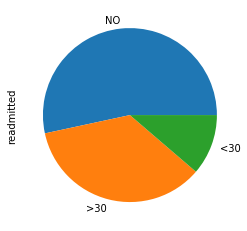

In [8]:
data['readmitted'].value_counts().plot.pie()

In [9]:
col_names = data.columns

In [10]:
data.diag_1 = data.diag_1.astype(str)
data.diag_2 = data.diag_2.astype(str)
data.diag_3 = data.diag_3.astype(str)
diag_dict = {}
# Circulatory
diag_dict[785] = 'Circulatory'
for i in range(390, 459):
    diag_dict[i] = 'Circulatory'
# Respiratory
diag_dict[786] = 'Respiratory'
for i in range(460, 519):
    diag_dict[i] = 'Respiratory'
# Digestive
diag_dict[787] = 'Digestive'
for i in range(520, 579):
    diag_dict[i] = 'Digestive'
# Injury
for i in range(800, 999):
    diag_dict[i] = 'Injury'
# Musculoskeletal
for i in range(710, 739):
    diag_dict[i] = 'Musculoskeletal'
# Genitourinary
for i in range(580, 629):
    diag_dict[i] = 'Genitourinary'
# Neoplasms
diag_dict[780] = 'Neoplasms'
diag_dict[781] = 'Neoplasms'
diag_dict[782] = 'Neoplasms'
diag_dict[784] = 'Neoplasms'
for i in range(140, 239):
    diag_dict[i] = 'Neoplasms'
for i in range(790, 799):
    diag_dict[i] = 'Neoplasms'
for i in range(240, 279):
    if i is 250:
        continue
    diag_dict[i] = 'Neoplasms'
for i in range(680, 709):
    diag_dict[i] = 'Neoplasms'
# Diabetes
for i in data.diag_1:
    if i.startswith("250"):
        diag_dict[i] = 'Diabetes'
for i in data.diag_1:
    if i not in diag_dict:
        diag_dict[i] = 'Other'

final_dict = {}
for k, v in diag_dict.items():
    final_dict[str(k)] = v

final_dict = pd.Series(final_dict)
data.diag_1 = data.diag_1.map(final_dict)
data.diag_2 = data.diag_2.map(final_dict)
data.diag_3 = data.diag_3.map(final_dict)
# print(len(data.diag_1.unique()))
# print(len(data.diag_2.unique()))
# print(len(data.diag_3.unique()))

In [11]:
# label encoding for only columns with categorical data
data.replace(to_replace=np.nan, value='?', inplace=True)
for col in data.columns:
    if col not in ['time_in_hospital', 
                   'num_lab_procedures', 
                   'num_procedures', 
                   'num_medications', 
                   'number_outpatient', 
                   'number_emergency', 
                   'number_inpatient', 
                   'number_diagnoses']:
        unique_elem = sorted(data[col].unique())
        if '?' in unique_elem:
            unique_elem = unique_elem[1:]
        data[col].replace(unique_elem, list(range(len(unique_elem))), inplace=True)
data.replace(to_replace='?', value=np.nan, inplace=True)

In [12]:
imputed_data = IterativeImputer(max_iter=100, random_state=0, initial_strategy='most_frequent').fit_transform(data.to_numpy())
# imputed_data = SimpleImputer(strategy='most_frequent').fit_transform(data.to_numpy())
data = pd.DataFrame.from_records(imputed_data)
data.columns = col_names

In [13]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2.0,0.0,1.0,0.0,0.0,6.0,3.0,16.293180,59.0,0.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,2.0,0.0,0.0,6.0,2.0,23.093085,11.0,5.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2,2.0,1.0,3.0,0.0,0.0,6.0,2.0,18.945816,44.0,1.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,2.0,1.0,4.0,0.0,0.0,6.0,1.0,15.978254,51.0,0.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,2.0,1.0,5.0,1.0,0.0,1.0,3.0,24.003817,31.0,6.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [14]:
ids = data.columns[:-1]
data[ids] = (data[ids] - data[ids].mean()) / (data[ids].std() + 1e-4)
data.head(5)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,0.396047,-0.924942,-3.287658,-0.707351,-0.524964,0.407501,-0.475073,-0.351390,0.804171,-0.790556,...,0.0,1.905345,-0.081685,-0.011416,-0.003097,0.0,-0.003097,-1.079375,0.54876,1.0
1,-1.926883,-0.924942,-2.646293,-0.707351,-0.524964,0.407501,-0.809166,0.138672,-1.630877,2.135806,...,0.0,-0.477883,-0.081685,-0.011416,-0.003097,0.0,-0.003097,0.926081,0.54876,2.0
2,0.396047,1.080616,-2.004928,-0.707351,-0.524964,0.407501,-0.809166,-0.160217,0.043218,-0.205284,...,0.0,1.905345,-0.081685,-0.011416,-0.003097,0.0,-0.003097,-1.079375,0.54876,2.0
3,0.396047,1.080616,-1.363563,-0.707351,-0.524964,0.407501,-1.143260,-0.374086,0.398330,-0.790556,...,0.0,0.713731,-0.081685,-0.011416,-0.003097,0.0,-0.003097,-1.079375,0.54876,2.0
4,0.396047,1.080616,-0.722198,-0.017799,-0.524964,-1.012969,-0.475073,0.204307,-0.616274,2.721079,...,0.0,0.713731,-0.081685,-0.011416,-0.003097,0.0,-0.003097,0.926081,0.54876,1.0


In [15]:
features = data.columns[:-1]
X = np.array(data[features]) # Features
y = np.array(data[data.columns[-1]]).astype(int) # Target variable
print("Input data shape", X.shape, "Output data shape", y.shape)

Input data shape (98053, 45) Output data shape (98053,)


In [16]:
kfold = StratifiedKFold(10, random_state=False, shuffle=True)

folds = kfold.split(X, y)
folds = [(train, test) for train, test in folds]

In [17]:
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=10, step=1)
selected = selector.fit(X[folds[0][1]], y[folds[0][1]])
print(selected.support_)
print(selected.ranking_)

[False False  True False False False False False False False False  True
  True  True False False False False False False False  True  True False
 False False False False False False False  True  True False  True False
 False False False  True False False False False False]
[29 14  1 10  3 15 17 18 20  7 11  1  1  1 23 22  8  4  6 16 26  1  1  2
  9 31 13 25 24  5 21  1  1 30  1 34 35 19 27  1 33 36 32 28 12]


In [18]:
selected_feat = []
for tak, (i, col) in zip(selected.support_, enumerate(data.columns[:-1])):
    if tak:
        print(col, i)
        selected_feat.append((col, i))
# gender 1
# age 2
# admission_type_id 3
# discharge_disposition_id 4
# admission_source_id 5
# num_procedures 9
# num_medications 10
# number_outpatient 11
# number_emergency 12
# number_inpatient 13
# diag_3 16
# number_diagnoses 17
# max_glu_serum 18
# A1Cresult 19
# repaglinide 21
# nateglinide 22
# chlorpropamide 23
# glimepiride 24
# glipizide 26
# pioglitazone 29
# acarbose 31
# miglitol 32
# tolazamide 34
# glipizide-metformin 39
# diabetesMed 44

age 2
number_outpatient 11
number_emergency 12
number_inpatient 13
repaglinide 21
nateglinide 22
acarbose 31
miglitol 32
tolazamide 34
glipizide-metformin 39


In [19]:
X_rfe = selector.transform(X)
X_rfe.shape

(98053, 10)

In [20]:
X_cs, y_cs = SMOTEENN(random_state=0).fit_resample(X_rfe, y)
print(X_cs.shape, y_cs.shape)

(14517, 10) (14517,)


In [22]:
np.save('npy_data/X_combinedSampling_10Features_task1.npy', X_cs)
np.save('npy_data/y_combinedSampling_10Features_task1.npy', y_cs)
np.save('npy_data/selected_features_10_task1.npy', selected_feat)

In [23]:
kfold = StratifiedKFold(10, random_state=False, shuffle=True)

kfolds = kfold.split(X_cs, y_cs)
folds = [(train, test) for train, test in kfolds]

In [24]:
data_classes = []
for i in range(3):
    data_classes.append(len(y_cs[y_cs==i]))

+-------------------+-----------------------+
|      XGBoost      | Avg. Accross 10 Folds |
+-------------------+-----------------------+
|   Training Time   |   2.1035999999999997  |
|      Accuracy     |   0.9268446953084508  |
| Balanced Accuracy |   0.9221843667806601  |
+-------------------+-----------------------+
+----------------+--------------------+--------------------+--------------------+
| Metric / Class |     Class - No     | Class - > 30 days  | Class - < 30 days  |
+----------------+--------------------+--------------------+--------------------+
|   Percision    | 0.8460495891984031 | 0.9374682204453597 | 0.9708360772266351 |
|     Recall     | 0.8755797434048042 | 0.9282102493979492 | 0.9627631075392269 |
|    F1-score    | 0.8604708370347849 | 0.9327685924832227 | 0.9666799563484471 |
|    Support     |       302.2        |       746.6        |       402.9        |
+----------------+--------------------+--------------------+--------------------+
+-----------+--------+

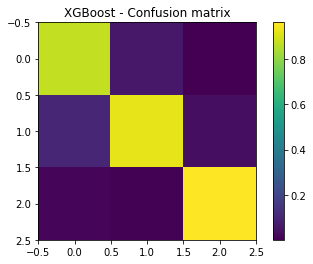

In [25]:
tables, xgboost_metrics = train_model(model_name='XGBoost', X=X_cs, y=y_cs, folds=folds, data_classes=data_classes)
table1, table2, conf_mat, conf_mat_norm = tables
print(table1)
print(table2)
print(conf_mat)
# Viewing the confusion matrix
plt.imshow(conf_mat_norm, interpolation='nearest')
plt.title('XGBoost - Confusion matrix')
plt.colorbar()
plt.show()

+-------------------+-----------------------+
|      AdaBoost     | Avg. Accross 10 Folds |
+-------------------+-----------------------+
|   Training Time   |         0.3115        |
|      Accuracy     |   0.762209258172857   |
| Balanced Accuracy |   0.7287659789076715  |
+-------------------+-----------------------+
+----------------+--------------------+--------------------+--------------------+
| Metric / Class |     Class - No     | Class - > 30 days  | Class - < 30 days  |
+----------------+--------------------+--------------------+--------------------+
|   Percision    |  0.71735547441378  | 0.731950180489781  | 0.923410795319558  |
|     Recall     | 0.732619718925535  | 0.8711473238799703 | 0.5825308939175092 |
|    F1-score    | 0.7247401815917249 | 0.795445947500125  | 0.7140662928192533 |
|    Support     |       302.2        |       746.6        |       402.9        |
+----------------+--------------------+--------------------+--------------------+
+-----------+--------+

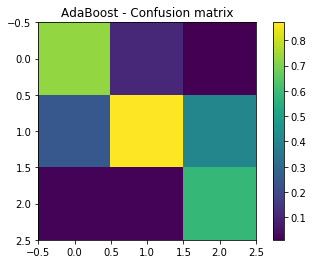

In [26]:
tables, adaboost_metrics = train_model(model_name='AdaBoost', X=X_cs, y=y_cs, folds=folds, data_classes=data_classes)
table1, table2, conf_mat, conf_mat_norm = tables
print(table1)
print(table2)
print(conf_mat)
# Viewing the confusion matrix
plt.imshow(conf_mat_norm, interpolation='nearest')
plt.title('AdaBoost - Confusion matrix')
plt.colorbar()
plt.show()

+-------------------+-----------------------+
|       XTrees      | Avg. Accross 10 Folds |
+-------------------+-----------------------+
|   Training Time   |  0.48040000000000005  |
|      Accuracy     |   0.9910448859245926  |
| Balanced Accuracy |   0.9908909812152649  |
+-------------------+-----------------------+
+----------------+--------------------+--------------------+--------------------+
| Metric / Class |     Class - No     | Class - > 30 days  | Class - < 30 days  |
+----------------+--------------------+--------------------+--------------------+
|   Percision    | 0.9751406465258322 | 0.9935520189612597 | 0.9985160738296053 |
|     Recall     | 0.9841147028610147 | 0.9895514138771351 | 0.9990068269076454 |
|    F1-score    | 0.9795824149312711 | 0.9915424791944364 | 0.9987592994756949 |
|    Support     |       302.2        |       746.6        |       402.9        |
+----------------+--------------------+--------------------+--------------------+
+-----------+--------+

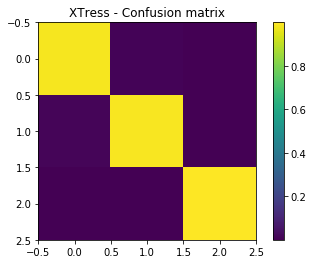

In [27]:
tables, xtrees_metrics = train_model(model_name='XTrees', X=X_cs, y=y_cs, folds=folds, data_classes=data_classes)
table1, table2, conf_mat, conf_mat_norm = tables
print(table1)
print(table2)
print(conf_mat)
# Viewing the confusion matrix
plt.imshow(conf_mat_norm, interpolation='nearest')
plt.title('XTress - Confusion matrix')
plt.colorbar()
plt.show()

+-------------------+-----------------------+
|        KNN        | Avg. Accross 10 Folds |
+-------------------+-----------------------+
|   Training Time   |  0.20660000000000003  |
|      Accuracy     |   0.9626638700772526  |
| Balanced Accuracy |    0.95785535703181   |
+-------------------+-----------------------+
+----------------+--------------------+--------------------+--------------------+
| Metric / Class |     Class - No     | Class - > 30 days  | Class - < 30 days  |
+----------------+--------------------+--------------------+--------------------+
|   Percision    | 0.921130636886671  | 0.9697056380403399 | 0.9810185200182124 |
|     Recall     | 0.9199200052455577 | 0.9670505076606695 | 0.9865955581892027 |
|    F1-score    | 0.9203875858442583 |  0.96835022488835  | 0.9837808331619478 |
|    Support     |       302.2        |       746.6        |       402.9        |
+----------------+--------------------+--------------------+--------------------+
+-----------+--------+

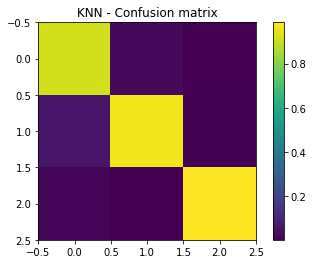

In [28]:
tables, knn_metrics = train_model(model_name='KNN', X=X_cs, y=y_cs, folds=folds, data_classes=data_classes)
table1, table2, conf_mat, conf_mat_norm = tables
print(table1)
print(table2)
print(conf_mat)
# Viewing the confusion matrix
plt.imshow(conf_mat_norm, interpolation='nearest')
plt.title('KNN - Confusion matrix')
plt.colorbar()
plt.show()

+-------------------+-----------------------+
|         DT        | Avg. Accross 10 Folds |
+-------------------+-----------------------+
|   Training Time   |         0.006         |
|      Accuracy     |   0.8680849437929196  |
| Balanced Accuracy |   0.8399312913400416  |
+-------------------+-----------------------+
+----------------+--------------------+--------------------+--------------------+
| Metric / Class |     Class - No     | Class - > 30 days  | Class - < 30 days  |
+----------------+--------------------+--------------------+--------------------+
|   Percision    | 0.8052583209940563 | 0.8592477490315515 | 0.9273548942792317 |
|     Recall     | 0.684645815574935  | 0.9133402241674471 | 0.9218078342777428 |
|    F1-score    | 0.7396351732052244 | 0.8853670241033209 | 0.9244033994325143 |
|    Support     |       302.2        |       746.6        |       402.9        |
+----------------+--------------------+--------------------+--------------------+
+-----------+--------+

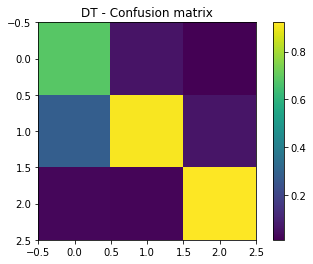

In [29]:
tables, dt_metrics = train_model(model_name='DT', X=X_cs, y=y_cs, folds=folds, data_classes=data_classes)
table1, table2, conf_mat, conf_mat_norm = tables
print(table1)
print(table2)
print(conf_mat)
# Viewing the confusion matrix
plt.imshow(conf_mat_norm, interpolation='nearest')
plt.title('DT - Confusion matrix')
plt.colorbar()
plt.show()